In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import transforms

torch.__version__

'1.13.1'

## Smile Classification from Face Images

In [2]:
image_path = './data/celabA/'

celeba_train_dataset = torchvision.datasets.CelebA(
    image_path,
    split='train',
    target_type='attr',
    download=True
)

celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path,
    split='valid',
    target_type='attr',
    download=True
)

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path,
    split='test',
    target_type='attr',
    download=True
)

print('Train set:', len(celeba_train_dataset))
print('Valid set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train set: 162770
Valid set: 19867
Test set: 19962


### Data Augmentation

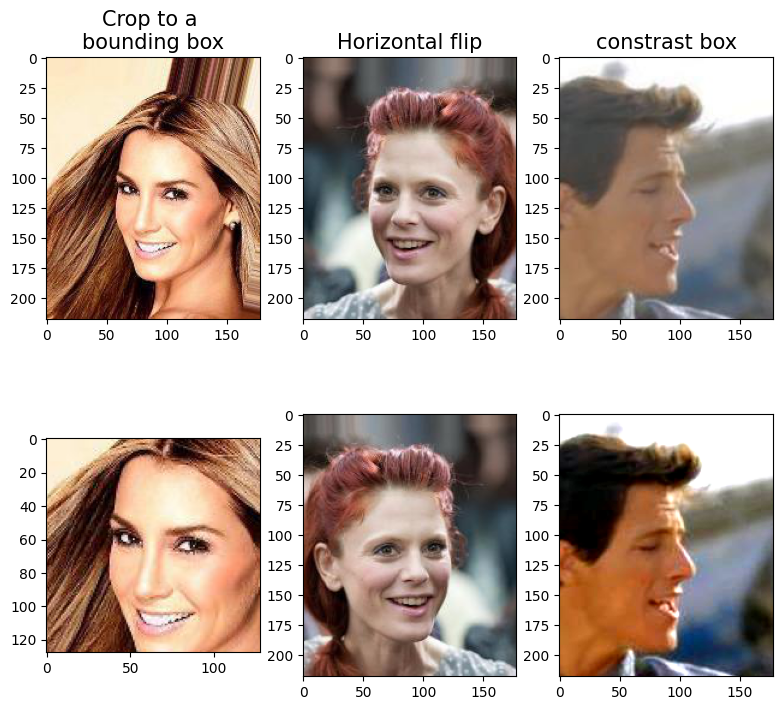

In [3]:
fig = plt.figure(figsize=(16, 8.5))

ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop to a \nbounding box', size=15)
ax.imshow(img)

ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train_dataset[1]
ax.set_title('Horizontal flip', size=15)
ax.imshow(img)

ax = fig.add_subplot(2, 5, 7)
img_cropped = transforms.functional.hflip(img)
ax.imshow(img_cropped)

ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train_dataset[2]
ax.set_title('constrast box', size=15)
ax.imshow(img)

ax = fig.add_subplot(2, 5, 8)
img_cropped = transforms.functional.adjust_contrast(img, 2)
ax.imshow(img_cropped)

In [4]:
get_smile = lambda attr: attr[31]

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor()
])

In [6]:
transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor()
])

In [7]:
from torch.utils.data import DataLoader

Files already downloaded and verified


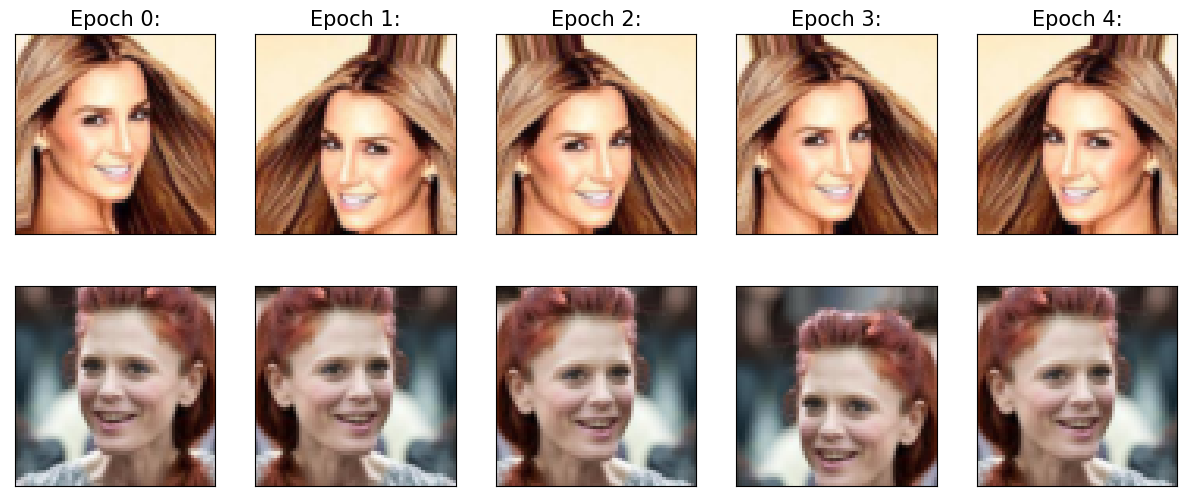

In [8]:
celeba_train_dataset = torchvision.datasets.CelebA(
    image_path,
    split='train',
    target_type='attr',
    download=True,
    target_transform=get_smile,
    transform=transform_train
)

torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size=2)

fig = plt.figure(figsize=(15, 6))
num_epochs = 5

for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))

    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j+6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

plt.show()

In [9]:
celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path,
    split='valid',
    target_type='attr',
    download=True,
    transform=transform,
    target_transform=get_smile
)

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path,
    split='test',
    target_type='attr',
    download=True,
    transform=transform,
    target_transform=get_smile
)

Files already downloaded and verified
Files already downloaded and verified


### Subsetting the training and valid data for a faster training


In [10]:
from torch.utils.data import Subset

In [11]:
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))

print(f"Train set:", len(celeba_train_dataset))
print(f"Valid set:", len(celeba_valid_dataset))

Train set: 16000
Valid set: 1000


In [12]:
batch_size = 32
torch.manual_seed(1)

train_dl = DataLoader(celeba_train_dataset, batch_size=1, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size=1, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size=1, shuffle=False)

In [13]:
device = 'cpu'

### CNN smile classifier

In [14]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.5),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.5),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.AvgPool2d(kernel_size=8),
    nn.Flatten(),
    nn.Linear(in_features=256, out_features=1),
)

In [15]:
x = torch.ones(size=(4, 3, 64, 64))
with torch.inference_mode():
    print(model(x).shape)

torch.Size([4, 1])


In [16]:
model = model.to(device=device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs

    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            pred_logits = model(x_batch)[:, 0]
            loss = loss_fn(pred_logits, y_batch.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_hist_train[epoch] += loss.item() * y_batch.size(0)

            pred_probs = torch.sigmoid(pred_logits)
            is_correct = ( (pred_probs >= 0.5).float() == y_batch ).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.inference_mode():
            for x_batch, y_batch in valid_dl:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                pred_logits = model(x_batch)[:, 0]
                loss = loss_fn(pred_logits, y_batch.float())

                pred_probs = torch.sigmoid(pred_logits)
                is_correct = ( (pred_probs >= 0.5).float() == y_batch ).float()

                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        if epoch % 1 == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss_hist_train[epoch]:.4f} | Train acc: {accuracy_hist_train[epoch]:.4f} | Val loss: {loss_hist_valid[epoch]:.4f} | Val acc: {accuracy_hist_valid[epoch]:.4f}")
        
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [21]:
torch.manual_seed(1)
num_epochs = 10
hist = train(model, num_epochs=num_epochs, train_dl=train_dl, valid_dl=valid_dl)

Epoch: 0 | Train Loss: 0.6671 | Train acc: 0.5922 | Val loss: 0.6811 | Val acc: 0.5450


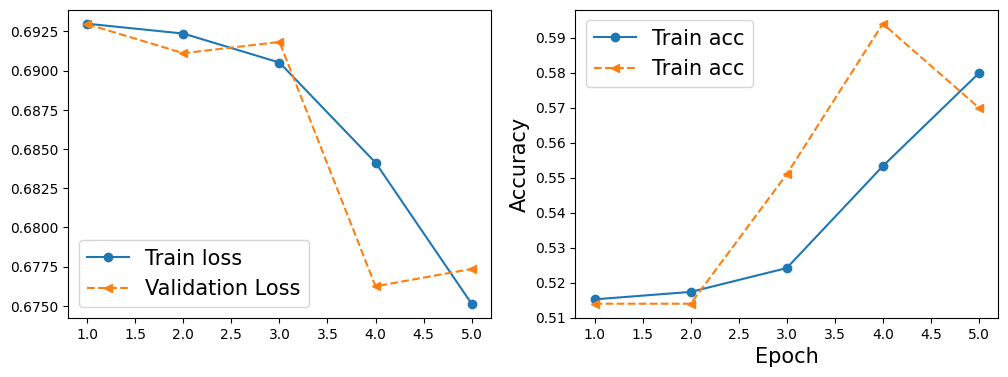

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation Loss')
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc')
ax.plot(x_arr, hist[3], '--<', label='Train acc')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

### Evaluation

In [ ]:
accuracy_test = 0

model.eval()
with torch.inference_mode():
    for x_batch, y_batch in test_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        preds_logits = model(x_batch)[:, 0]
        is_correct = ( (preds_logits >= 0.5).float() == y_batch ).float() 
        accuracy_test += is_correct.sum()

    accuracy_test /= len(test_dl.dataset)

print(f"Test accuracy: {accuracy_test:.4f}")

In [ ]:
pred = torch.sigmoid( model(x_batch) )[:, 0] * 100
fig = plt.figure(figsize=(15, 7))

for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1, 2, 0))

    if y_batch[j] == 1:
        label = "Smile"
    else:
        label = "Not Smile"

    ax.text(0.5, -0.15, f"GT: {label:s}\nPr(Smile)={pred[j]:.0f}%", size=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.show()